# Section 10. word2vec

## 1. Overview

### What is word2vec
- Word2Vec is used for learning word embeddings - somewhere we will start with a VxD matrix, and transform it to a VxD2 matrix (D2 would be the number of reduced dimensions specified for the word embedding)
- Word2vec takes care of two things:
    - Converts high dimensional vector (size V) into low dimensional vector (lets say, 200)
    - Maintains the word context (meaning) by using **one of two algorithms:**
        1. Continuous Bag-of-Words (CBOW): predicts one word based on the surrounding words (it takes a window sized context as an observation)
        2. Skip-gram model: It takes one word as an input and tries to predict the surrounding (neighboring) words.

### Building up word2vec: 2 options
- We will start by building a simple bigrams model (next word prediction), this is simply a markov model because each word is conly conditioned on one previous value
- We will then alter our simple bigram model by adding CBOW, and then by adding skip-gram (**NOTE these are two different models so we will look at them independently**)
- The final models will look something like this:

![](pictures/NLP_10_word2vec.png)

## 2. Start with a Bigram Model

- To start, we will build a simple neural bigram model (essentially a markov model).
- What does the model look like:
    - We have a VxD input to hidden matrix, 
    - 1 hidden layer
    - DxV output layer
- to train this model, we still just use what we already know:
    - one target word per training session (set output to 'next word'), 
    - perform softmax, cross-entropy, gradient descent, the usual!
- We will have a single hidden layer with **NO NON-LINEAR FUNCTION.** The value just passes through. This is essentially just a linear mapping from previous word to next word. 

![](pictures/NLP_10_bigrams.PNG)

#### Simple example:
Since there isn't any non-linearity (no non-linear activation function), this is really just a linear model
- y = softmax(W^2 \* W^1 \* X) 
- This is pretty much logistic regression!!! WHy dont we just use that?!? We wouldnt need gradient descent and that could save time maybe?!?!
- in fact, this model is kind of like a mariage between logisitic regression and markov models
- The V x V matrix (W2 * W1) is a Markov matrix! Each row is the probabilitiy of the next word
- You can pretty much use the maximum liklehood function, with add one smoothing, to solve this equation

Lets take 2 sentences:
- "I love dogs"
- "I love cats
- V = 4: [i, love, dogs, cats]

In [1]:
import numpy as np
vocab =['i', 'love', 'dogs', 'cats'] 

#last two rows are 0 because no words come after 'dogs' or 'cats'
markov_mat = np.array([[0,1,0,0],
                       [0,0,0.5,0.5],
                       [0,0,0,0],
                       [0,0,0,0]])
print(vocab)
print(markov_mat)

['i', 'love', 'dogs', 'cats']
[[ 0.   1.   0.   0. ]
 [ 0.   0.   0.5  0.5]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]]


In [10]:
import numpy as np
np.random.choice([1,2,3,4],5,[0.1,0.1,0.1,0.6])sam

array([4, 2, 3, 3, 3])

- This model is only SIMILAR to logistic regression. 
    - if you multiply W1 by W2 you get a VXV matrix
- So how is it different?
    - Well if we directly use logistic regression our weights would be:
        - V=2000, 2000\*2000 = 4 million weights
    - Useing the neural bigram model with D=100 (hidden layer size):
        - V=2000, size(W2) + size(W1) = 2000\*100 + 2000\*100 = 400k

**As you can see, our bigram model has 10x less weights!!! We learned this from our earlier bigram work... it turns out that our neural network actually trains faster than the logisitc regression, and it is precisely beacause D helps us significantly reduce the number of weights!!!**

        

## 3. Bigram model with CBOW
- CBOW (continuous bag of words) will be our first modification to our simple bigram model
- CBOW basically adds context so can better predict a word given surrounding words (rather than just using the previous word)
- We will use a context size of 5-10 words (10 left + 10 right)
- How do we modify our neural net to use CBOW?
    - Just add more inputs to the neural network! Input becomes fat but output becomes same side. 
    - We use the **same weight everywhere on the left FOR EVERY INPUT (ie every one-hot word)**, but words are one-hot encoded (so only 1 row from W goes into the hidden layer).
        - So each (one-hot word \* weight) just results in a single weight vector FOR EVERY WORD getting fed into the hidden layer (so this isn't necessarily shared weights)
- Now what happens at the hidden layer?
    - Well if we have 10 input vectors, then we will have 10 D dimenstional vectors at the hidden layer, and we somehow have to match that to a DxV output matrix to get the output.
        - what we do with CBOW is just take the average of those vectors
        - Sum them up, divide by 10, and now we have 1 D dimensional vector to be passed along to output

![](pictures/NLP_10_cbow1.png)

## 4. Bigram model with skip-gram
- CBOW and skip-gram are the 2 main methods of incorporating context with word2vec
- skip-gram is the opposite of CBOW
    - CBOW = use context to predict middle word
    - skip-gram = use middle word to predict context
- In skipgram, the input remains the same, and the output gets fat!
- Notice that it is now the output weight that is repeated on the right hand side (see pictutre below). 


- OK! So we know that softmax is for predicting ONE class onle. Meaning that out of V words, softmax chooses 1 (chooses option with highest probabilitiy)
- But now we are telling the neural net to predict 10 words from a single hidden layer?!?
- We will go into this more later... but for now, know this:
    - **Cost = sum up individual cross-entropies as usual (joint probabilitiy)**
    - As if they were each different bigram samples
    - In other words, create more 'bigrams' by 'skipping' the words in between
    
![](pictures/NLP_10_skipgram1.png)


### REMEMBER, its the hidden layer weights that will become our word embedding vectors!

![](pictures/NLP_10_word2vec2.png)


## 5. Negative sampling (Skip gram)

- We need a way to reduce the number of weights... because with massive vocabs it will simply be too cumbersome. 
- So... If we have K words in the CONTEXT, then there are K TARGETS. There will be K(V-1) words that are NOT the target (if we used softmax)
- A LOT of times is spent to make words not the target... so heres the basic idea:
    - **NEGATIVE SAMPLING: Throw away most of the non-target words (not in the context) from the cost function since its almost the size of the entire vocab**. 
- So we don't need to tell the neural network that all V-1 words are not the target all the time, we only need to do this SOME of the time. 
- We sample words from a set of words not in the context - "negative samples"
- Choose a small amount (ie. 10)

#### How to choose samples?
- Typically we sample from the uniform distribution, or a function of the word frequency / its probability of appearing, p(w) = count(w)/total
- We call this sampling distribution Pn(W)
- Research has shown that if we take the initial distribution and raise it to the power of 0.75, that works even better!
- Why? well, if a word appears a lot in a corpus, but its not in the context, we want to get away from it.
- Word probabilities have a long tail distribution (many words appear very infrequently), so we balance this by raising it to the power of 0.75 (give infrequent words a better chance of being selected)

#### New cost function
- So now we have a way of generating negative samples, rather than using EVERY word thats not the target
- But now we can't use cross entropy with softmax
- Instead we use the equation word below.
- NOTE that we take the negative log of the context terms (because we want to maximize the probability of these words showing up, and the negative of a log is a positive... Also as the prob increases, log(prob) decreases (which is what we want as we are trying to minimize the cost function)!!!

![](pictures/NLP_10_word2vec3.1.png)

#### Differentiate

![](pictures/NLP_10_word2vec4.1.png)

#### Strangeness
![](pictures/NLP_10_word2vec5.1.png)

# 6. Take a step back... 

Stolen from: https://www.quora.com/What-are-the-continuous-bag-of-words-and-skip-gram-architectures 

For clarification, here is a good description of what we've learned so far:

- Both architectures [CBOW and skip-gram] describe how the neural network "learns" the underlying word representations for each word. **Since learning word representations is essentially unsupervised, you need some way to "create" labels to train the model.** Skip-gram and CBOW are two ways of creating the "task" for the neural network -- you can think of this as the output layer of the neural network, where we create "labels" for the given input (which depends on the architecture).

For both descriptions below, we assume that the current word in a sentence is wi.

- **CBOW:** The input to the model could be [wi−2, wi−1, wi+1, wi+2] (this is the context), the preceding and following words of the current word we are at. The output of the neural network will be wi. Hence you can think of the task as **"predicting the word given its context"**. Note that the number of words we use depends on your setting for the window size.
    
    
- **Skip-gram:** The input to the model is wi, and the output could be [wi−1, wi−2, wi+1, wi+2]. So the task here is **"predicting the context given a word"**.  
    - **Defining the random window size:** When you define the window size parameter, you ONLY CONFIGURE THE MAX WINDOW SIZE. The actual window size is randomly chosen between 1 (the minimum window) and max size for each training sample. This results in words directly next to the target word ALWAYS showing up in context, and words with maximum distance (maximum window size) showing up with probability of 1/c (where c is context size).
    - **Negative Sampling:** In addition, more distant words are given less weight by randomly sampling them.

According to Mikolov:
- Skip-gram: works well with small amount of the training data, represents well even rare words or phrases.
- CBOW: several times faster to train than the skip-gram, slightly better accuracy for the frequent words
- This can get even a bit more complicated if you consider that there are two different ways how to train the models: the normalized hierarchical softmax, and the un-normalized negative sampling. Both work quite differently.

which makes sense since with skip gram, you can create a lot more training instances from limited amount of data, and for CBOW, you will need more since you are conditioning on context, which can get exponentially huge.

# Lets write some Code!

# 1. Import packages

In [85]:
import json
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime
from nltk.corpus import brown
import operator
import os
import sys
import matplotlib.pyplot as plt

# 2. Import old code

In [114]:
#GET SENTENCES FROM BROWN CORPUS
def get_sentences():
    # returns 57340 of the Brown corpus
    # each sentence is represented as a list of individual string tokens
    return brown.sents()
test = get_sentences()

#SENTANCES TO INDEX REPRESENTATION WITH LIMITED VOCAB
KEEP_WORDS = set([
  'king', 'man', 'queen', 'woman',
  'italy', 'rome', 'france', 'paris',
  'london', 'britain', 'england',
])

def get_sentences_with_word2idx_limit_vocab(n_vocab=2000, n_sent=None, keep_words=None, print_v=False):
    #initialize sentences and index
    sentences = get_sentences()
    if n_sent:
        idx = np.random.choice(len(sentences),n_sent, replace=False)
        sentences=[sentences[x] for x in idx]
    
    indexed_sentences = []
    i = 2
    #initialize start/end tags
    #capitalized so wont get confused with actual words in corpus
    word2idx = {'START': 0, 'END': 1}
    idx2word = ['START', 'END']
    
    #Set start tokens to inf so they dont get removed when sorting by count
    word_idx_count = {0: float('inf'), 1: float('inf')}
    
    #Count each word 
    for sentence in sentences:
        indexed_sentence = []
        for token in sentence:
            token = token.lower()
            if token not in word2idx:
                idx2word.append(token)
                word2idx[token] = i
                i += 1
            # keep track of counts for later sorting
            idx = word2idx[token]
            word_idx_count[idx] = word_idx_count.get(idx, 0) + 1

            indexed_sentence.append(idx)
        indexed_sentences.append(indexed_sentence)

    # restrict vocab size
    # set all the words I want to keep to infinity
    # so that they are included when I pick the most
    if keep_words:
        for word in keep_words:
            word_idx_count[word2idx[word]] = float('inf')
    #tell sorted funciton to use 2nd item to sort
    sorted_word_idx_count = sorted(word_idx_count.items(), key=operator.itemgetter(1), reverse=True)
    word2idx_small = {}
    new_idx = 0
    #create new dictionary from old dict
    idx_new_idx_map = {}
    for idx, count in sorted_word_idx_count[:n_vocab]:
        word = idx2word[idx]
        if print_v:
            print(word, count)
        word2idx_small[word] = new_idx
        idx_new_idx_map[idx] = new_idx
        new_idx += 1
    # let 'unknown' be the last token
    # replcae all infrequent words are replaced with 'UNKOWN"
    word2idx_small['UNKNOWN'] = new_idx 
    unknown = new_idx
    
    # sanit check to make sure all words wanted to keep are still there
    assert('START' in word2idx_small)
    assert('END' in word2idx_small)
    if keep_words:
        for word in keep_words:
            assert(word in word2idx_small)

    # map old idx to new idx
    sentences_small = []
    for sentence in indexed_sentences:
        if len(sentence) > 1:
            new_sentence = [idx_new_idx_map[idx] if idx in idx_new_idx_map else unknown for idx in sentence]
            sentences_small.append(new_sentence)

    return sentences_small, word2idx_small

#create the find_analogies function
def find_analogies(w1, w2, w3, We, word2idx):
    king = We[word2idx[w1]]
    man = We[word2idx[w2]]
    woman = We[word2idx[w3]]
    v0 = king - man + woman

    def dist1(a, b):
        return np.linalg.norm(a - b)
    def dist2(a, b):
        return 1 - a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

    for dist, name in [(dist1, 'Euclidean'), (dist2, 'cosine')]:
        min_dist = float('inf')
        best_word = ''
        for word, idx in word2idx.items():
            if word not in (w1, w2, w3):
                v1 = We[idx]
                d = dist(v0, v1)
                if d < min_dist:
                    min_dist = d
                    best_word = word
        print("closest match by", name, "distance:", best_word)
        print(w1, "-", w2, "=", best_word, "-", w3)

# 3. Create sigmoid and init_weights functions
- NOTE: we will put these into the model class afterwards so we dont have to run this cell before.

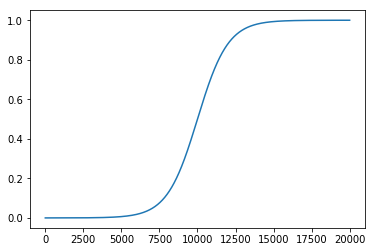

In [16]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

plt.plot([sigmoid(x) for x in np.arange(-10,10,0.001)])
plt.show()

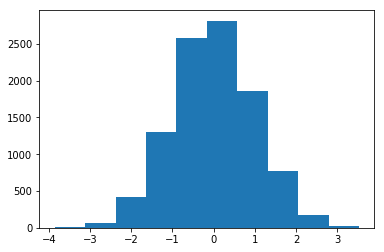

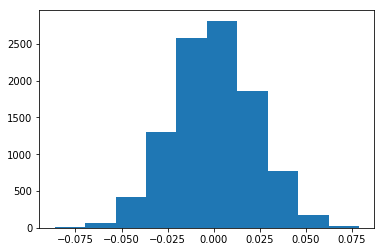

In [38]:
def init_weights(shape):
    return np.random.randn(*shape).astype(np.float32) / np.sqrt(sum(shape))

#rand gives you normal distribution with std of 1.. aprox?
rand_data = np.random.randn(10000)
plt.hist(rand_data)
plt.show()

#dividing be sqrt of shape just makes weights smaller
shape=(1000,1000)
plt.hist(rand_data/np.sqrt(sum(shape)))
plt.show()

# 4. Create w2v_model class

In [198]:
class w2v_model:
    def __init__(self, h_size, v_size, context_size):
        self.h_size = h_size #hidden layer / embedding dimension
        self.v_size = v_size #total vocab size
        self.context_size = context_size #num of context words
    
    # Include functions defined above
    def _model_sigmoid(self, x):
        return 1 / (1+np.exp(-x))
    def _init_model_weights(self, shape):
        return np.random.randn(*shape).astype(np.float32) / np.sqrt(sum(shape))
    
    # Create private function to get word probabilitiy
    # Calculate Pn(w) - probabilitiy distribution for negative sampling
    # Basically just the word probabilitiy ^ 3/4
    def _get_word_probs(self, X):
        # 1. GET WORD FREQUENCY FOR EACH WORD IN ENTIRE CORPUS
        word_freq = {}
        word_count = sum(len(x) for x in X)
        for x in X:
            for xj in x:
                if xj not in word_freq:
                    word_freq[xj] = 0
                word_freq[xj] += 1
        # 2. GET ADJUSTED WORD PROBABILITY DISYTRIBUTION.
        # Raise normal probability to power of 0.75 to make infrequent words more likely to be picked
        self.word_probs = np.zeros(self.v_size)
        for j in range(2, self.v_size): #ignore 0 and 1 (start/end tokens)
            self.word_probs[j] = (word_freq[j] / float(word_count)) ** 0.75
        
        # 3. MAKE SURE ALL WORDS HAVE ABOVE 0 PROBABILITY
        assert(np.all(self.word_probs[2:]>0))
        return self.word_probs
    
    # Extract negative sample words
    def _get_negative_samples(self, context, num_neg_samples):
        # 1. EXCLUDE CURRENT CONTEXT WORDS (make prob 0)
        saved = {}
        for context_idx in context:
            # First save the probability to restore later
            saved[context_idx] = self.word_probs[context_idx]
            # Now make the probability 0
            self.word_probs[context_idx] = 0
        # 2. EXTRACT NEGATIVE SAMPLES
        # Use replace=False to get all unique values
        neg_samples = np.random.choice(range(self.v_size),
                                       size = num_neg_samples,
                                       replace = False,
                                       p = self.word_probs / np.sum(self.word_probs)) #adjust word_probs to reflect removal of target words
        # 3. ADD BACK CURRENT TARGET WORDS TO self.word_probs
        for j, orig_prob in saved.items():
            self.word_probs[j] = orig_prob
        # 4. MAKE SURE ALL WORDS HAVE ABOVE 0 PROBABILITY
        assert(np.all(self.word_probs[2:]>0))
        return neg_samples
    
    # Fit the model!
    def fit(self, X, num_neg_samples=10, learning_rate=1e-4, momentum=0.99, reg=0.1, epochs=10, plot_data=True):
        # 1. SET PARAMS
        N = len(X)
        V = self.v_size
        D = self.h_size
        # 2. GET WORD PROBS (self.attribute defined within the function)
        self._get_word_probs(X)
        # 3. INITIALIZE WEIGHTS AND MOMENTUM CHANGES
        self.W1 = self._init_model_weights((V,D))
        self.W2 = self._init_model_weights((D,V))
        dW1 = np.zeros(self.W1.shape) #used for updated weights during gradient descent
        dW2 = np.zeros(self.W2.shape) #used for updated weights during gradient descent
        # 4. RUN MODEL
        sample_indices = range(N)
        cost_per_epoch = []
        cost_per_batch = []
        for i in range(epochs):
            t0 = datetime.now()
            sample_indices = shuffle(sample_indices) #randomize order of sentences
            costs_single_epoch = []
            for i2 in range(N): #for each sentence...
                x = X[sample_indices[i2]] #one sentence / batch
                
                # SKIP SENTENCE IF TOO SHORT (ie now large enough for context)
                if len(x) < (2*self.context_size+1):
                    continue #'continue' will revert to previous loop
                                
                # SELECT RANDOM WORD IN SENT FOR TARGET, SELECT THAT WORD IN WIEIGHT MATRIX
                sent_len = len(x)
                target_word_idx = np.random.choice(sent_len)
                W1_select = self.W1[x[target_word_idx],:] #should be a (1,D) matrix
                
                # DEFINE START, END, AND CONTEXT
                start = max(0, target_word_idx - self.context_size)
                end = min(sent_len, target_word_idx + self.context_size + 1) #add plus one so its inclusive!
                context = np.concatenate([x[start:target_word_idx], x[target_word_idx+1:end]]) #exclude target word
                context = np.array(list(set(context)), dtype=np.int32) # NOTE: Context can contain duplicates (E.g. "<UNKOWN> <UNKOWN> cats and dogs")
                
                # POSITIVE DOT PRODUCT CALCULATION 
                # Result should be (1,context) matrix)
                # Linear activation (tho I guess NO activation...) so you can just do W1.dot(W2)
                W2_select = self.W2[:,context] #should be a (D, context) matrix
                posA = W1_select.dot(W2_select)
                pos_pY = self._model_sigmoid(posA)
                
                # NEGATIVE DOT PRODUCT CALCULATION
                # Result should be (1,neg_samples) matrix)
                neg_samples = self._get_negative_samples(context, num_neg_samples)
                W2_select = self.W2[:,neg_samples] #should be a (D, neg_samples) matrix
                negA = W1_select.dot(W2_select)
                neg_pY = self._model_sigmoid(-negA)
                
                # CALCULATE COST
                cost = -np.log(pos_pY).sum() - np.log(neg_pY).sum()
                cost_normalized = cost/(num_neg_samples+len(context)) #normalize the cost for length
                cost_per_batch.append(cost_normalized)
                costs_single_epoch.append(cost_normalized)
                
                # UPDATE OUTPUT WEIGHTS (W2)
                # t=1 if context, t=0 if negative_samps (see the gradient formulas!)
                pos_err = pos_pY - 1
                neg_err = 1 - neg_pY
                dW2[:, context] = momentum*dW2[:,context] - learning_rate*(np.outer(W1_select, pos_err) + reg*self.W2[:,context])
                dW2[:, neg_samples] = momentum*dW2[:,neg_samples] - learning_rate*(np.outer(W1_select, neg_err) + reg*self.W2[:,neg_samples])
                self.W2[:,context] += dW2[:,context]
                self.W2[:, neg_samples] += dW2[:, neg_samples]
                
                # UPDATE INPUT WEIGHTS
                gradW1 = pos_err.dot(self.W2[:, context].T) + neg_err.dot(self.W2[:, neg_samples].T)
                dW1[x[target_word_idx],:] = momentum*dW1[x[target_word_idx],:] - learning_rate*(gradW1 + reg*self.W1[x[target_word_idx],:])
                self.W1[x[target_word_idx],:] += dW1[x[target_word_idx],:]
                
                # PRINT RESULTS
                if i2  % 5000 == 0:
                    print("Epoch: {0}, Doc: {1}, Cost: {2}".format(i, i2, cost_normalized))
            
            # APPEND COST PER EPOCH
            epoch_mean = np.mean(costs_single_epoch)
            cost_per_epoch.append(epoch_mean)
            
            # PRINT RUNTIME
            print("Epoch runtime: {}\nEpoch cost: {}".format(datetime.now() - t0, epoch_mean))

        # PLOT DATA
        if plot_data:
            plt.plot(cost_per_batch)
            plt.title("All batch costs")
            plt.show()
            plt.plot(cost_per_epoch)
            plt.title("All epoch costs")
            plt.show()
        
        # SAVE MODEL USING np.savez
        def save(self, filename):
            arrays = [self.W1, self.W2]
            np.savez(filename, *arrays)   

# 5. Extract data

In [199]:
sentences, word2idx = get_sentences_with_word2idx_limit_vocab(n_vocab=10000, n_sent=20000)
V=len(word2idx)
print('Sentences: ',len(sentences))
print('Vocab: ',V)

Sentences:  19889
Vocab:  10001


# 6. Test out the model!
Word embeddings will be trash, but we want to make sure it is atleast running!

Epoch: 0, Doc: 0, Cost: 0.6931338906288147
Epoch: 0, Doc: 5000, Cost: 0.6931207444932725
Epoch: 0, Doc: 10000, Cost: 0.6931262969970703
Epoch: 0, Doc: 15000, Cost: 0.6930629328677529
Epoch runtime: 0:00:30.331703
Epoch cost: 0.6931399593790246
Epoch: 1, Doc: 0, Cost: 0.6931395212809245
Epoch: 1, Doc: 5000, Cost: 0.6925421357154846
Epoch: 1, Doc: 10000, Cost: 0.6931401421042049
Epoch runtime: 0:00:30.833839
Epoch cost: 0.6926305739465092
Epoch: 2, Doc: 0, Cost: 0.6929059028625488
Epoch: 2, Doc: 5000, Cost: 0.6931503931681315
Epoch: 2, Doc: 10000, Cost: 0.6937103867530823
Epoch: 2, Doc: 15000, Cost: 0.6528512636820475
Epoch runtime: 0:00:28.576168
Epoch cost: 0.6884375594566878
Epoch: 3, Doc: 0, Cost: 0.6999445597330729
Epoch: 3, Doc: 5000, Cost: 0.6925846548641429
Epoch: 3, Doc: 10000, Cost: 0.6931924819946289
Epoch: 3, Doc: 15000, Cost: 0.6823043823242188
Epoch runtime: 0:00:28.909493
Epoch cost: 0.6851106723739254
Epoch: 4, Doc: 5000, Cost: 0.6931370183041221
Epoch: 4, Doc: 10000, Cos

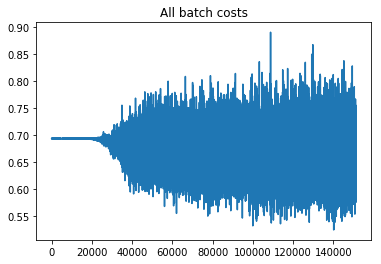

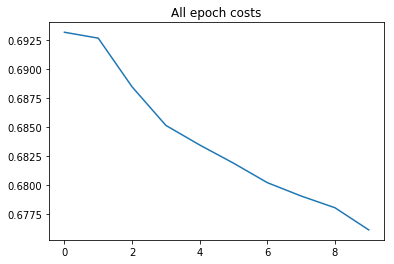

In [200]:
model = w2v_model(h_size=10, v_size=V, context_size=5)
model.fit(sentences, num_neg_samples=10, learning_rate=1e-4, momentum=0.99, reg=0.1, epochs=10, plot_data=True)

# 7. Import pre-trained word embeddings

What you could do is save your own word embeddings (the crappy ones you trianed above), but they suck, and training good ones from scratch requires a lot of data and time... SO, we will use the pre-trained embeddings (trained using theano, which we wont use, as we will do a tensor flow implementation later). But for good measure, here is how you save the embeddings:
    
    # Super easy!
    model.save('w2v_model.npz')
    
Now, lets load the old embeddings and try to some word analogies.

In [216]:
# Set gitrepo path
path = "C:\\Users\\mciniello\\Desktop\\Python\\NLP\\LazyProgrammer\\LazyProgrammerGitRepos\\nlp_class2"

# Load pretrained embeddings
npz = np.load(os.path.join(path,'w2v_model.npz'))
W1 = npz['arr_0']
W2 = npz['arr_1']

# Load word2idx used for training
with open(os.path.join(path,'w2v_word2idx.json')) as f:
    word2idx = json.load(f)

# 8. Join W1 and W2 to create word embeddings
There are two ways to concat W1 and W2 to create word embedding:

1) Concatenate:


    We = np.hstack([W1, W2.T])
    print("We.shape:", We.shape)
    assert(V == We.shape[0])

2) Average:


    We = (W1 + W2.T) / 2
    
We will use concat here.

In [215]:
We_stacked = np.hstack([W1, W2.T])
We_average = (W1+W2.T)/2

print("Original shapes: ", W1.shape, W2.shape)
print("Stacked shape: ", We_stacked.shape)
print("Average shape: ", We_average.shape)


Original shapes:  (2001, 10) (10, 2001)
Stacked shape:  (2001, 20)
Average shape:  (2001, 10)


# 9. Find anologies

In [220]:
def find_analogies(w1, w2, w3, concat=True, word2idx=word2idx, W1=W1, W2=W2):
    V = len(word2idx)

    if concat:
        We = np.hstack([W1, W2.T])
        assert(V == We.shape[0])
    else:
        We = (W1 + W2.T) / 2

    _find_analogies(w1, w2, w3, We, word2idx)

In [221]:
find_analogies('king', 'man', 'woman')
find_analogies('france', 'paris', 'london')
find_analogies('france', 'paris', 'rome')
find_analogies('paris', 'france', 'italy')

closest match by Euclidean distance: canadian
king - man = canadian - woman
closest match by cosine distance: atlantic
king - man = atlantic - woman
closest match by Euclidean distance: european
france - paris = european - london
closest match by cosine distance: throughout
france - paris = throughout - london
closest match by Euclidean distance: following
france - paris = following - rome
closest match by cosine distance: general
france - paris = general - rome
closest match by Euclidean distance: permanent
paris - france = permanent - italy
closest match by cosine distance: alloys
paris - france = alloys - italy
